# Resnet50 classification with OpenVINO

This tutorial demonstrates the use of Resnet50 in OpenVino.The model information could be found [here](https://docs.openvino.ai/latest/omz_models_model_resnest_50_pytorch.html).

# What is Resnet?

Residual Network (ResNet) is one of the famous deep learning models that was introduced by Shaoqing Ren, Kaiming He, Jian Sun, and Xiangyu Zhang in their paper. The paper was named “Deep Residual Learning for Image Recognition”  in 2015. The ResNet model is one of the popular and most successful deep learning models so far.

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 x 10^9 Floating points operations. It is a widely used ResNet model in research.

Resnet consist of a residual block architecture. These skip connection help us in solving the degradtion problem that occurs in other convolution based neural network. An example of skip connection is if you are training a neural network and if you pass the output from one of the hidden layer you have received to the other layer, you may notice that the output after passing to the next layer may be degarded compared to the previous output and this can cause the model to have inferior weights. Residual or skip connection helps us solving this problem by comapring the previous output with the current output and if the previous one is better than it will skip the current output and pass it onto the next layer.

# Preparation



Before working on the model inference, we will first download the resnet-50 model with the help of omz_downloader. If you dont have it installed in your machine, you can install it via this link [here](https://github.com/openvinotoolkit/open_model_zoo/blob/master/tools/model_tools/README.md).
You can download the model with the help of the "!omz_downloader --name resnet-50-pytorch" command and convert it to OpenVino format with the "!omz_converter --name resnet-50-pytorch" command"

Use the omz_converter to convert the pytorch fp32 model to OpenVino FP32 and FP16 IR format

# Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core
from pathlib import Path

# Settings

In [2]:
DEVICE = "CPU"
MODEL_FILE = "model/resnet-50-pytorch.xml"
model_xml_path = Path(MODEL_FILE)
MODEL_WEIGHTS = "model/resnet-50-pytorch.bin"
model_weights_path = Path(MODEL_WEIGHTS)

# Functions

In [3]:
def resize_image(data):
    image = cv2.cvtColor(cv2.imread(data), code=cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(src=image, dsize=(224, 224))
    return input_image

# Load the model

Load the model in Inference Engine with `ie.read_model` and compile it for the specified device with `ie.compile_model`. Get input and output keys and the expected input shape for the model.

In [4]:
ie = Core()
model = ie.read_model(model=model_xml_path,weights=model_weights_path)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)

# The input key contains information and shape of the model input
input_key = next(iter(compiled_model.inputs))
# The output key contains information and shape of the model output
output_key = next(iter(compiled_model.outputs))

# Load,Resize and reshape the Image
The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (N=number of images,  C=number of channels, H=height, W=width). 

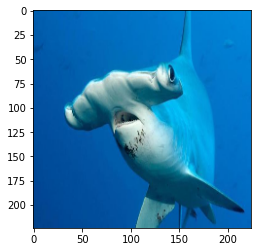

In [5]:
IMAGE_NAME = 'data/hammer.jpg'

# resize to input shape for network
resized_image = resize_image(IMAGE_NAME)

# reshape image to network input shape NCHW
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
plt.imshow(resized_image)

### Do inference on image
Pass the image for inference to the model, get the output and use np.argmax to extract the most probable class.

In [6]:
result_infer = compiled_model(inputs=[input_image])[output_key]
result_index = np.argmax(result_infer)

### Get output Label

Pass on the output model label extacted from the output array to the imagenet class list to get the label file

In [7]:
# Convert the inference result to a class name.
imagenet_classes = open("imagenet_1000.txt").read().splitlines()
output = imagenet_classes[result_index]

In [8]:
print('the output class label is  = ',output)

the output class label is  =  hammerhead, hammerhead shark
